In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle

In [3]:
PATH = '/home/paperspace/data/pneumonia/'

## TODO
- all metadata in dicom
- file sizes - All train are 1024x1024

In [18]:
det_class_path = f'{PATH}stage_1_detailed_class_info.csv'
bbox_path = f'{PATH}stage_1_train_labels.csv'
dicom_dir = f'{PATH}train/'

28989 class infos loaded
25684 patient cases


,patientId,class
17258,a53a67ff-caf0-442f-b514-260795b6cd3a,No Lung Opacity / Not Normal
22925,cebe35bb-d11c-44a8-994d-587d157c0e30,Normal
18607,af111247-46cb-4cf0-a65f-cce25bdc0e2a,No Lung Opacity / Not Normal


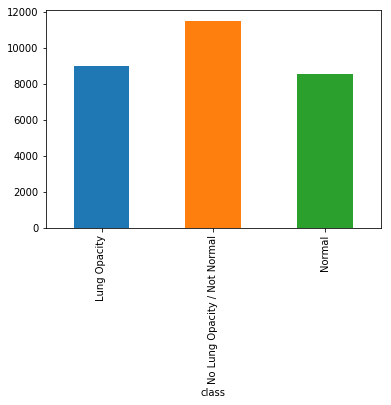

In [8]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

In [9]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

28989 boxes loaded
25684 patient cases


,patientId,x,y,width,height,Target
8224,5da96579-cc2c-4437-8830-4069e7da2a16,NaN,NaN,NaN,NaN,0
3101,362642f9-cda6-438a-8672-935c6191220c,22.0,208.0,355.0,703.0,1
11258,756c590a-3916-41af-96f8-fd9615725f76,NaN,NaN,NaN,NaN,0


In [10]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

28989 combined cases


,patientId,x,y,width,height,Target,class
21026,bee1ab01-cbef-4d86-96aa-41c77bffa6b3,48.0,231.0,225.0,617.0,1,Lung Opacity
4905,425d97a7-c5ce-4380-ba60-5a01a6618e08,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
26298,eadab655-474b-4bdf-9018-0adb6dbed310,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


# Distribution of Boxes and Labels
The values below show the number of boxes and the patients that have that number.

In [12]:
box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')


,boxes,patients
0,1,22506
1,2,3062
2,3,105
3,4,11


In [13]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,8964
1,No Lung Opacity / Not Normal,0,11500
2,Normal,0,8525


In [23]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

25684 images found


,BodyPartExamined,ViewPosition,PatientSex
count,25684,25684,25684
unique,1,2,2
top,CHEST,PA,M
freq,25684,13979,14593


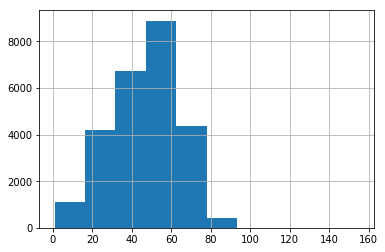

In [49]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex', 'Rows', 'Columns']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [50]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')
image_bbox_df = pd.merge(comb_box_df, 
                         image_full_df, 
                         on='patientId',
                        how='left')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.sample(10)

28989 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,Rows,Columns
9850,6aa660eb-06a5-45de-9819-84da5b02e787,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/6aa660eb...,60,CHEST,PA,M,1024,1024
19920,b7d86d4e-7d73-4269-bd19-3d24b7f4259b,537.0,450.0,152.0,129.0,1,Lung Opacity,1,/home/paperspace/data/pneumonia/train/b7d86d4e...,62,CHEST,AP,F,1024,1024
16423,9eefe353-2aa9-4e95-85bd-c1db14bd66b0,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/9eefe353...,73,CHEST,PA,M,1024,1024
25050,e0acfc04-c3ac-4017-881d-485ac151dad5,NaN,NaN,NaN,NaN,0,Normal,1,/home/paperspace/data/pneumonia/train/e0acfc04...,56,CHEST,PA,M,1024,1024
12865,82475321-76c4-44da-8799-38399abe8037,NaN,NaN,NaN,NaN,0,Normal,1,/home/paperspace/data/pneumonia/train/82475321...,73,CHEST,PA,M,1024,1024
17468,a6d95e82-3d6c-4047-abf2-505f059cdf17,200.0,310.0,211.0,436.0,1,Lung Opacity,1,/home/paperspace/data/pneumonia/train/a6d95e82...,60,CHEST,PA,M,1024,1024
5485,4721a511-43ae-4f06-99f6-724174a6da03,NaN,NaN,NaN,NaN,0,Normal,1,/home/paperspace/data/pneumonia/train/4721a511...,47,CHEST,PA,F,1024,1024
1038,0c2e9b99-9a8f-4b44-854e-acd181a0208c,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/0c2e9b99...,33,CHEST,PA,F,1024,1024
3940,3bb338a0-7e3d-4248-8731-a8daffa15e58,339.0,284.0,162.0,199.0,1,Lung Opacity,1,/home/paperspace/data/pneumonia/train/3bb338a0...,53,CHEST,AP,M,1024,1024
16975,a34a19f6-2c94-4e4c-afe0-373e16cd7dfc,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/a34a19f6...,63,CHEST,AP,M,1024,1024


In [54]:
image_bbox_df.describe()

,x,y,width,height,Target,boxes,PatientAge,Rows,Columns
count,8964.000000,8964.000000,8964.000000,8964.000000,28989.000000,28989.000000,28989.000000,28989.0,28989.0
mean,391.456158,363.135877,220.845382,334.174364,0.309221,1.237538,46.790645,1024.0,1024.0
std,203.945378,148.607149,59.041384,158.097239,0.462180,0.460392,16.916193,0.0,0.0
min,2.000000,2.000000,40.000000,45.000000,0.000000,1.000000,1.000000,1024.0,1024.0
25%,205.000000,246.000000,180.000000,207.000000,0.000000,1.000000,34.000000,1024.0,1024.0
50%,320.000000,360.000000,219.000000,304.000000,0.000000,1.000000,49.000000,1024.0,1024.0
75%,591.000000,475.000000,261.000000,445.000000,1.000000,1.000000,59.000000,1024.0,1024.0
max,817.000000,881.000000,528.000000,942.000000,1.000000,4.000000,155.000000,1024.0,1024.0


In [57]:
image_bbox_df.isna().sum()

patientId               0
x                   20025
y                   20025
width               20025
height              20025
Target                  0
class                   0
boxes                   0
path                    0
PatientAge              0
BodyPartExamined        0
ViewPosition            0
PatientSex              0
Rows                    0
Columns                 0
dtype: int64

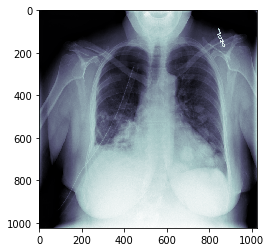

In [46]:
path = image_bbox_df.iloc[0].path
dicom = pydicom.read_file(path)
plt.imshow(dicom.pixel_array, cmap='bone')

In [48]:
dicom

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [56]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,Rows,Columns
0,77265ac1-7a24-44df-9969-41cbd6c29263,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/77265ac1...,12,CHEST,AP,M,1024,1024
1,15c181df-7b7c-47d3-ac5a-130b6047c1a0,NaN,NaN,NaN,NaN,0,Normal,1,/home/paperspace/data/pneumonia/train/15c181df...,61,CHEST,PA,M,1024,1024
2,e5c3b5c2-7f2f-426c-bf4f-ea8862da8dc3,386.0,198.0,144.0,144.0,1,Lung Opacity,1,/home/paperspace/data/pneumonia/train/e5c3b5c2...,29,CHEST,AP,F,1024,1024
3,e9e58e10-2795-4dec-a738-c9792ea8f685,144.0,366.0,247.0,448.0,1,Lung Opacity,2,/home/paperspace/data/pneumonia/train/e9e58e10...,28,CHEST,AP,M,1024,1024
4,e9e58e10-2795-4dec-a738-c9792ea8f685,582.0,412.0,228.0,372.0,1,Lung Opacity,2,/home/paperspace/data/pneumonia/train/e9e58e10...,28,CHEST,AP,M,1024,1024
5,36d7ebd2-a4e5-42d1-bde0-c7699da0b152,538.0,179.0,232.0,256.0,1,Lung Opacity,3,/home/paperspace/data/pneumonia/train/36d7ebd2...,62,CHEST,AP,F,1024,1024
6,36d7ebd2-a4e5-42d1-bde0-c7699da0b152,514.0,634.0,224.0,288.0,1,Lung Opacity,3,/home/paperspace/data/pneumonia/train/36d7ebd2...,62,CHEST,AP,F,1024,1024
7,36d7ebd2-a4e5-42d1-bde0-c7699da0b152,155.0,177.0,240.0,576.0,1,Lung Opacity,3,/home/paperspace/data/pneumonia/train/36d7ebd2...,62,CHEST,AP,F,1024,1024
8,8dc8e54b-5b05-4dac-80b9-fa48878621e2,281.0,163.0,201.0,253.0,1,Lung Opacity,4,/home/paperspace/data/pneumonia/train/8dc8e54b...,76,CHEST,AP,M,1024,1024
9,8dc8e54b-5b05-4dac-80b9-fa48878621e2,602.0,189.0,245.0,347.0,1,Lung Opacity,4,/home/paperspace/data/pneumonia/train/8dc8e54b...,76,CHEST,AP,M,1024,1024


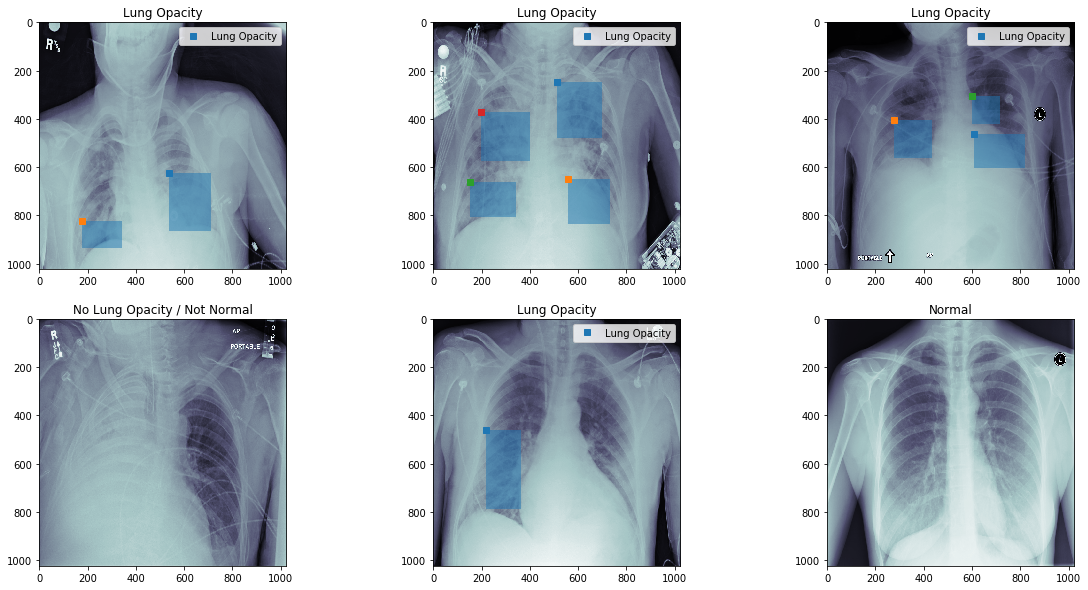

In [28]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

Bounding Box Distribution

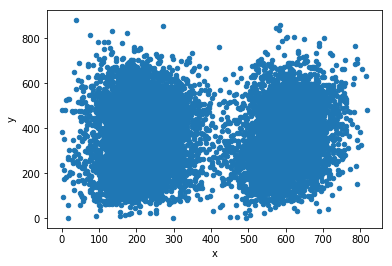

In [31]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

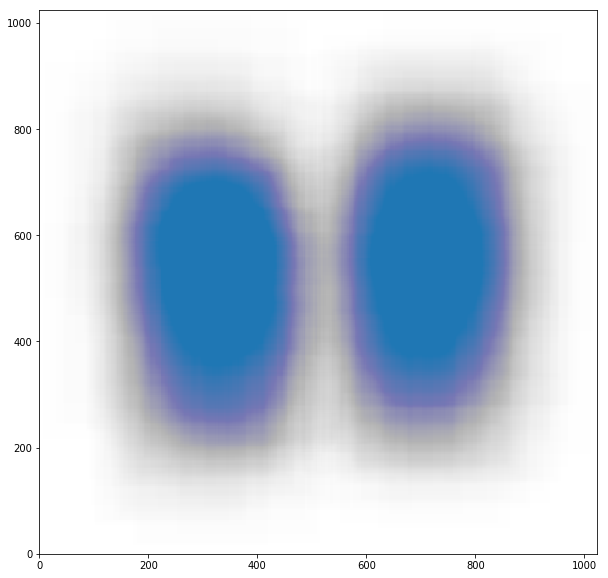

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

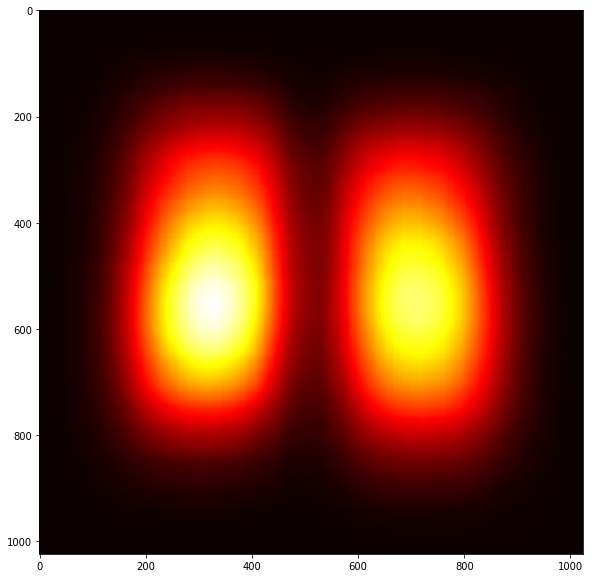

In [33]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

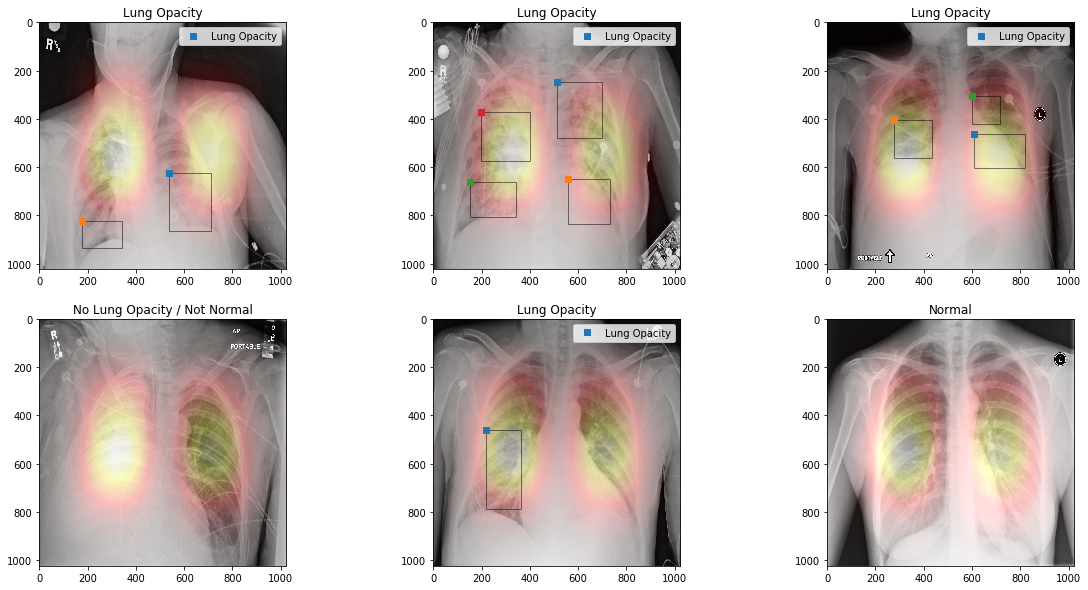

In [34]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)

In [36]:
image_bbox_df.to_csv(f'{PATH}image_bbox_full.csv', index=False)